In [214]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import sklearn.linear_model as lm
import sklearn.ensemble as ens
import sklearn.neural_network as nn

In [215]:
def natural_sort(l):
    def convert(text): return int(text) if text.isdigit() else text.lower()

    def alphanum_key(key): return [convert(c)
                                   for c in re.split('([0-9]+)', key)]
    return sorted(l, key=alphanum_key)

In [251]:
infer_method = "ridge_CV"

In [252]:
dataset_path = "mtist_datasets_joao"
es_score_path = f"mtist_datasets_joao/{infer_method}_inference_result"
n_dset = len([i for i in os.listdir(es_score_path) if "inferred" in i])

dataset_files = [i for i in os.listdir(dataset_path) if i.split("_")[0]=="dataset" and int(re.findall("_([0-9]+).csv", i)[0]) < n_dset]
dataset_files = natural_sort(dataset_files)

In [253]:
es_scores = pd.read_csv(f"{es_score_path}/{infer_method}_es_scores.csv", index_col=0)
# new_es_scores = pd.read_csv(f"{es_score_path}/new_es_scores.csv", index_col=0)

In [254]:
def samp_scheme_conv(scheme):
    if scheme == "even":
        return 0
    elif scheme == "seq":
        return 1
    else:
        return 2

In [255]:
dset_param_cols = ["n_species", "n_timeseries", "n_timepoints", "noise", "sampling_scheme", "dt"]
dset_param_vals = []

for dset in dataset_files:
    df = pd.read_csv(f"{dataset_path}/{dset}", index_col=0)
    df["sampling_scheme"] = samp_scheme_conv(df["sampling_scheme"][0])
    # df["dt"] = pd.DataFrame(np.diff(df["time"])[np.diff(df["time"])>=0]).mode().values[0,0]
    df["dt"] = np.round(np.median(np.diff(df["time"])[np.diff(df["time"])>=0]), 6)
    dset_param_vals.append(np.unique(df[dset_param_cols], axis=0))

In [256]:
df = pd.DataFrame(np.concatenate(dset_param_vals), columns=dset_param_cols)
df["es_score_raw"] = es_scores
# df[["new_es_score_raw", "new_es_score_floored"]] = new_es_scores

df

,n_species,n_timeseries,n_timepoints,noise,sampling_scheme,dt,es_score_raw
0,10.0,1.0,10.0,0.1,0.0,3.333333,0.50
1,10.0,1.0,20.0,0.1,0.0,1.515152,0.57
2,10.0,1.0,30.0,0.1,0.0,0.909091,0.58
3,10.0,1.0,40.0,0.1,0.0,0.909091,0.52
4,10.0,1.0,50.0,0.1,0.0,0.606061,0.62
...,...,...,...,...,...,...,...
9995,10.0,40.0,10.0,0.1,0.0,3.333333,0.71
9996,10.0,40.0,20.0,0.1,0.0,1.515152,0.70
9997,10.0,40.0,30.0,0.1,0.0,0.909091,0.75
9998,10.0,40.0,40.0,0.1,0.0,0.909091,0.74


In [257]:
n_sp = 10.
df_n_sp = df[df.n_species==n_sp]
# df_n_sp = df_n_sp[df_n_sp["seq_depth"]==1.]
feat = df_n_sp.iloc[:,[1,2,4,5]].values
label = df_n_sp["es_score_raw"].values
# new_label = df_n_sp["new_es_score_raw"].values

In [258]:
lr = lm.LinearRegression()
lr.fit(feat, label)
lr.score(feat, label)

0.5324171621585061

In [259]:
lr.coef_

array([ 0.00379197,  0.00031139,  0.        , -0.03520869])

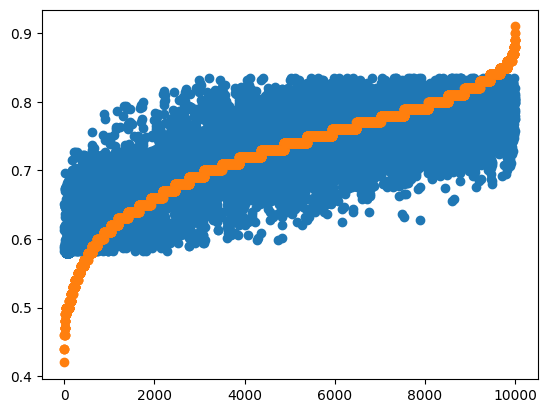

In [260]:
plt.plot(lr.predict(feat)[np.argsort(label)], "o")
plt.plot(label[np.argsort(label)], "o")

0.6207745075554165


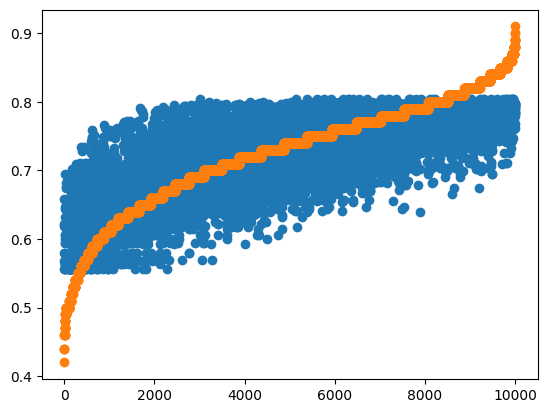

In [261]:
rfr = ens.RandomForestRegressor(100)
rfr.fit(feat, label)
print(rfr.score(feat, label))

plt.plot(rfr.predict(feat)[np.argsort(label)], "o")
plt.plot(label[np.argsort(label)], "o")

0.6196340227985856


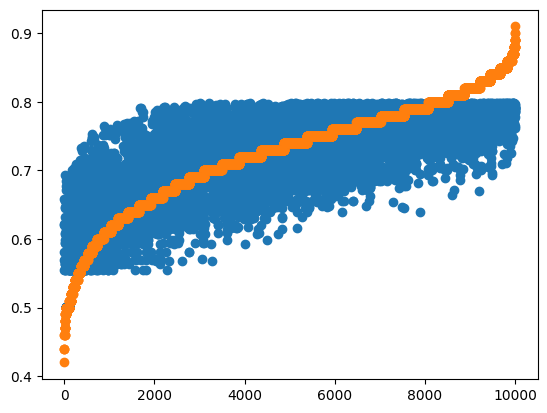

In [262]:
gfr = ens.GradientBoostingRegressor()
gfr.fit(feat, label)
print(gfr.score(feat, label))

plt.plot(gfr.predict(feat)[np.argsort(label)], "o")
plt.plot(label[np.argsort(label)], "o")

---

In [263]:
df["noise"].unique()

array([0.1])

In [264]:
df["n_timepoints"].unique()

array([10., 20., 30., 40., 50.])

In [265]:
df["n_timeseries"].unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40.])

In [266]:
df["sampling_scheme"].unique()

array([0.])

In [267]:
np.sort(df["dt"].unique())

array([0.606061, 0.909091, 1.515152, 3.333333])

In [268]:
lr.intercept_, lr.coef_

(0.6893935570823313,
 array([ 0.00379197,  0.00031139,  0.        , -0.03520869]))

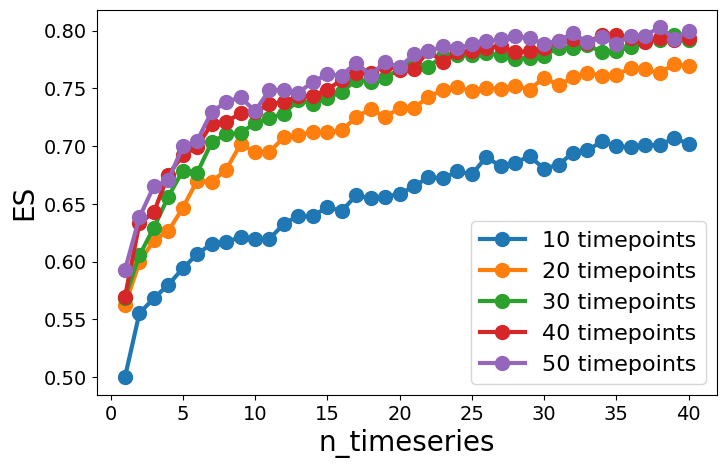

In [269]:
plt.figure(figsize=(8,5))
for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=10, lw=3, label=f"{n_tp:.0f} timepoints")

# plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

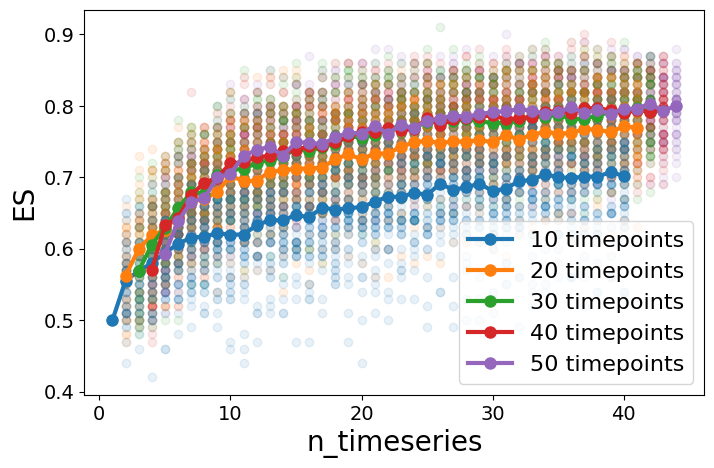

In [270]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp["n_timepoints"].unique()):
        plt.scatter((n_ts+j)*np.ones_like(df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{j}", alpha=0.1)

for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i+j for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{n_tp:.0f} timepoints")

# plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [271]:
df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values

array([0.81, 0.81, 0.83, 0.79, 0.8 , 0.85, 0.72, 0.82, 0.83, 0.84, 0.82,
       0.75, 0.88, 0.76, 0.84, 0.85, 0.81, 0.77, 0.76, 0.78, 0.82, 0.81,
       0.76, 0.73, 0.79, 0.86, 0.84, 0.81, 0.74, 0.81, 0.75, 0.76, 0.78,
       0.81, 0.79, 0.79, 0.83, 0.85, 0.79, 0.83, 0.8 , 0.78, 0.86, 0.78,
       0.79, 0.81, 0.81, 0.84, 0.7 , 0.74])

In [272]:
[i+j for i in df["n_timepoints"].unique()]

[14.0, 24.0, 34.0, 44.0, 54.0]

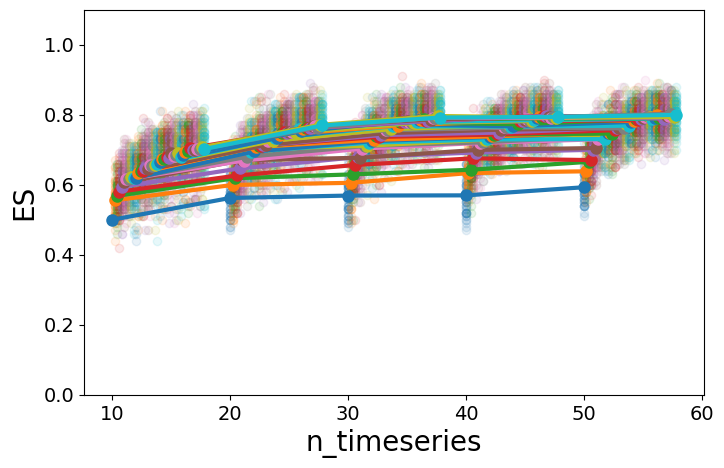

In [273]:
plt.figure(figsize=(8,5))

for j, n_tp in enumerate(df_n_sp["n_timepoints"].unique()):
    for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
        plt.scatter((n_tp+i/5)*np.ones_like(df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{i}", alpha=0.1)

for j, n_tp in enumerate(df["n_timeseries"].unique()):
    plt.plot([i+j/5 for i in df["n_timepoints"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[i,n_tp]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timepoints"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{n_tp:.0f} timepoints")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
# plt.legend(loc="lower right", fontsize=16)
plt.show()

In [274]:
df["sampling_scheme"].unique()

array([0.])

In [275]:
samp_schem = ["even", "random", "seq"]

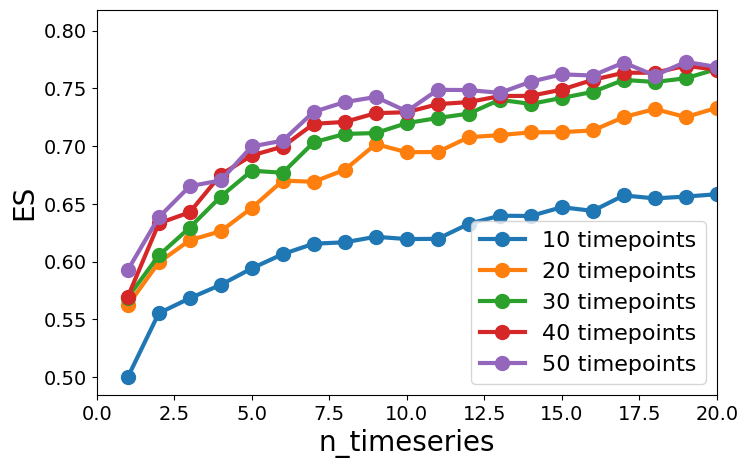

In [276]:
plt.figure(figsize=(8,5))

for j, n_tp in enumerate(df["n_timepoints"].unique()):
    plt.plot([i for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["n_timepoints", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=10, lw=3, label=f"{n_tp:.0f} timepoints")

# plt.ylim(0, 1)
plt.xlim(0, 20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [243]:
df["n_timepoints"].unique()

array([10., 20., 30., 40., 50.])

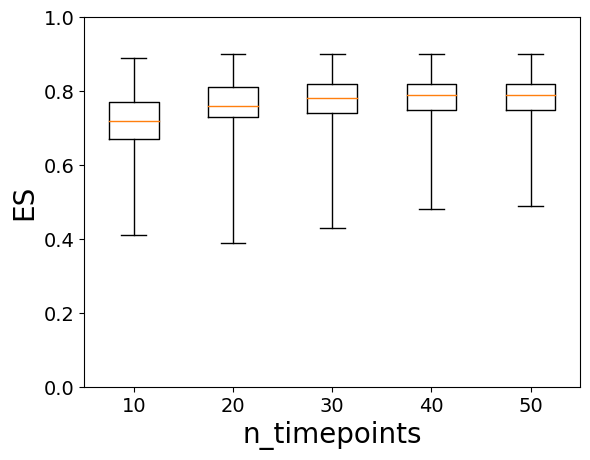

In [244]:
for i, n_ts in enumerate(df["n_timepoints"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["n_timepoints"]]==[n_ts]).all(1).values]["es_score_raw"].values, positions=[i], 
                whis=(0,100), widths=0.5)

plt.xticks(np.arange(len(df["n_timepoints"].unique())), labels=df["n_timepoints"].unique().astype(int))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timepoints", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.ylim(0, 1)
plt.show()

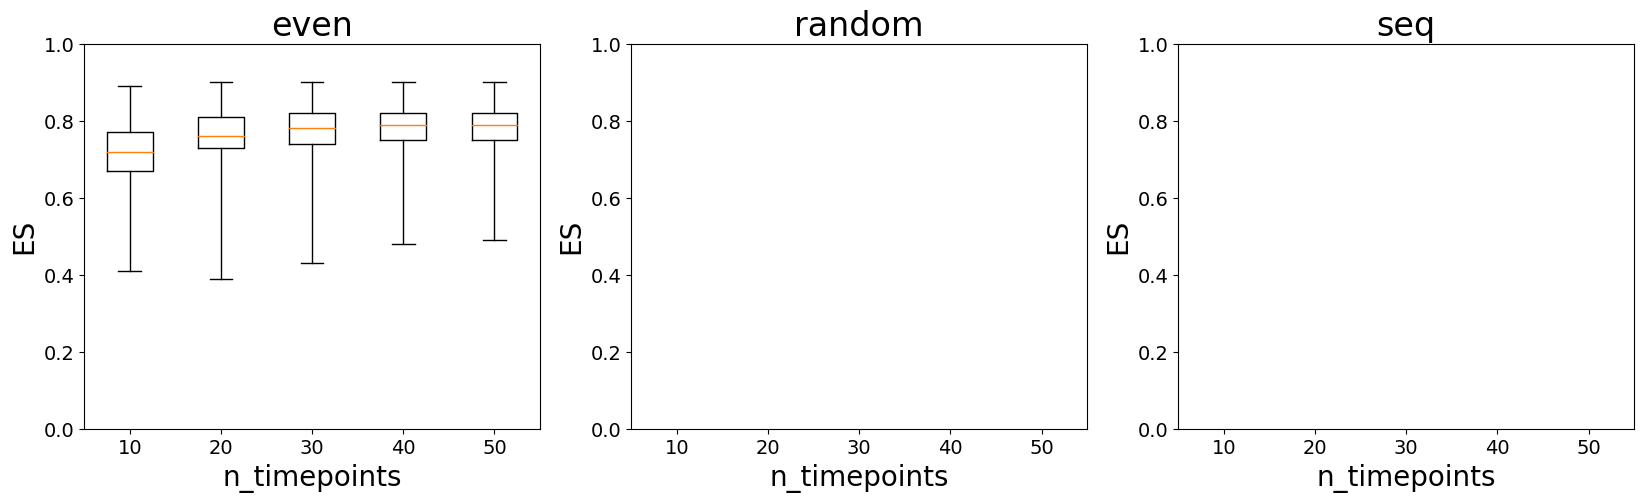

In [245]:
plt.subplots(1, 3, figsize=(20,5))
for j in range(3):
    plt.subplot(1, 3, j+1)
    for i, n_ts in enumerate(df["n_timepoints"].unique()):
        plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timepoints"]]==[j,n_ts]).all(1).values]["es_score_raw"].values, positions=[i], 
                    whis=(0, 100), widths=0.5)

    plt.xticks(np.arange(len(df["n_timepoints"].unique())), labels=df["n_timepoints"].unique().astype(int))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("n_timepoints", fontsize=20)
    plt.ylabel("ES", fontsize=20)
    plt.ylim(0, 1)
    plt.title(samp_schem[j], fontsize=24)
plt.show()

ValueError: num must be an integer with 1 <= num <= 6, not 7

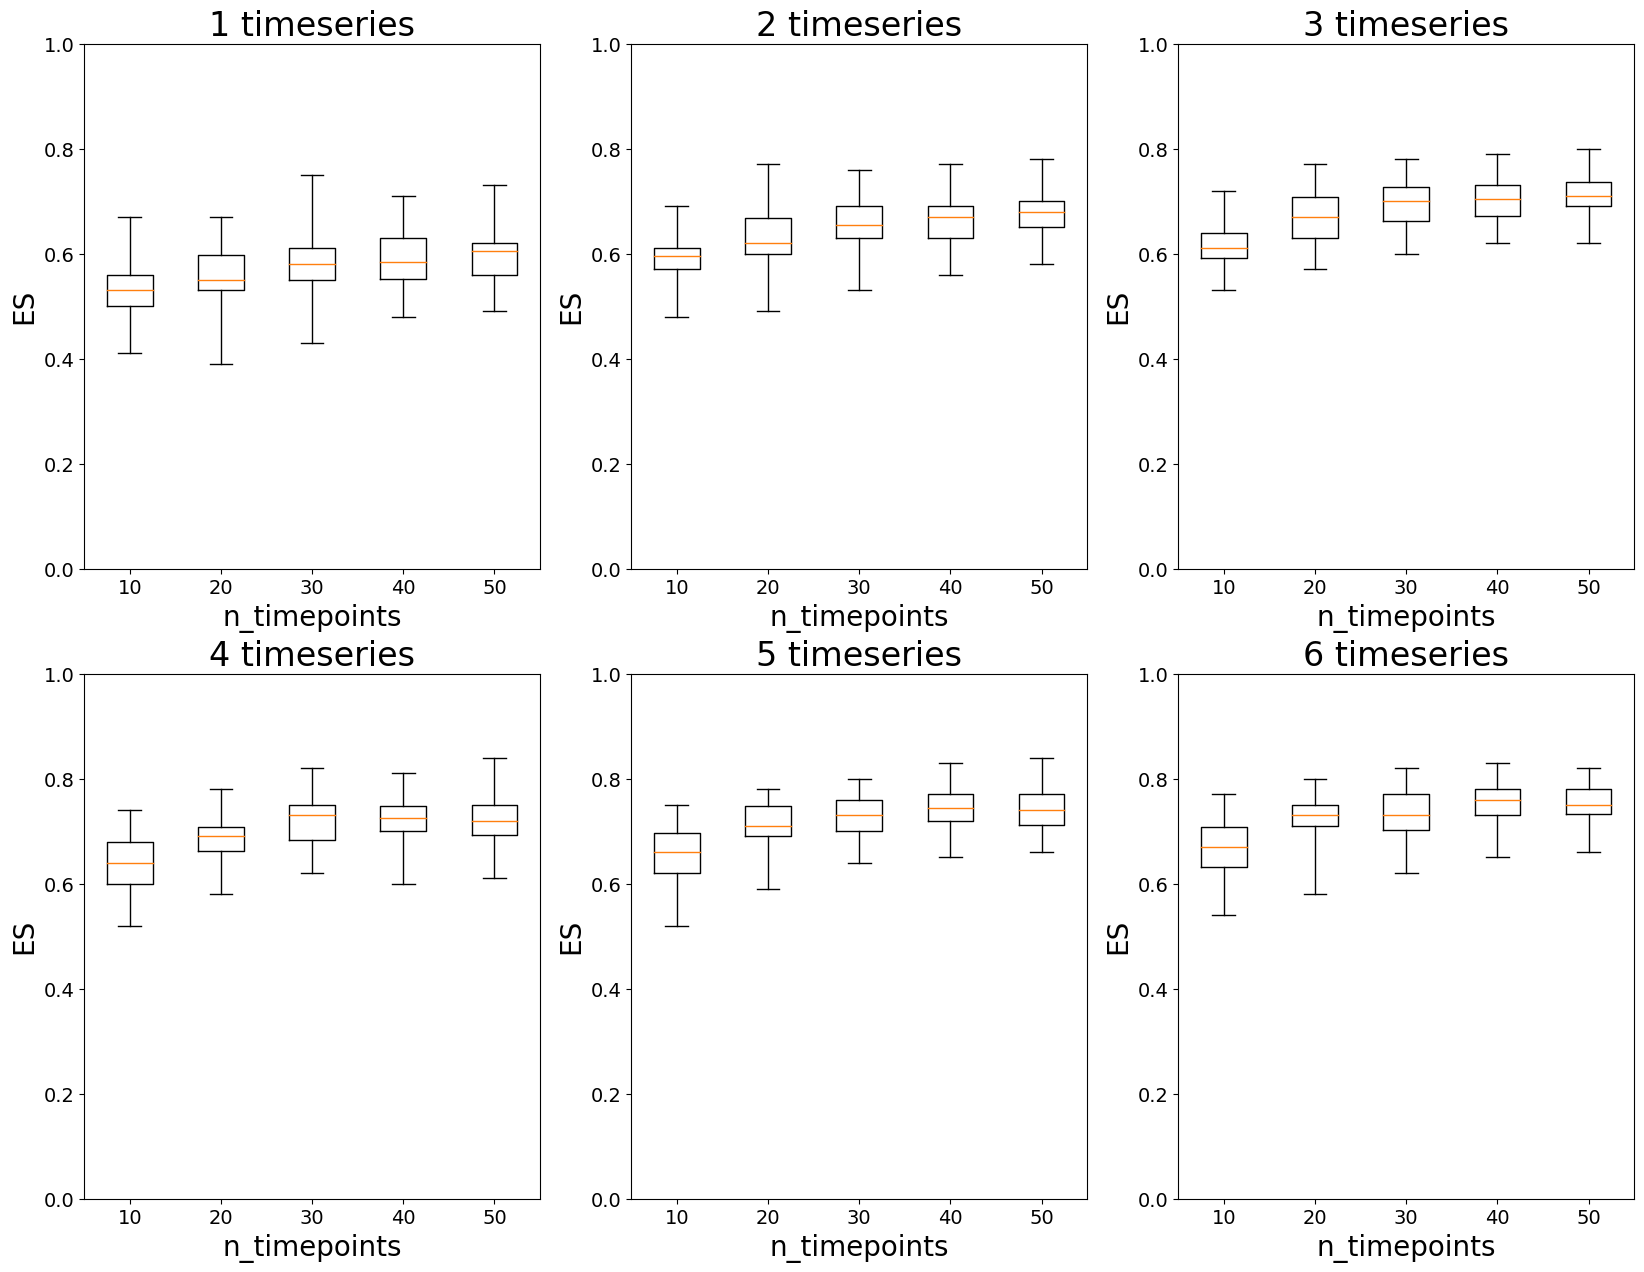

In [246]:
plt.subplots(2, 3, figsize=(20,15))
for j, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    plt.subplot(2, 3, j+1)
    for i, n_tp in enumerate(df["n_timepoints"].unique()):
        plt.boxplot(df_n_sp[(df_n_sp[["n_timeseries", "n_timepoints"]]==[n_ts,n_tp]).all(1).values]["es_score_raw"].values, positions=[i], 
                    whis=(0, 100), widths=0.5)

    plt.xticks(np.arange(len(df["n_timepoints"].unique())), labels=df["n_timepoints"].unique().astype(int))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("n_timepoints", fontsize=20)
    plt.ylabel("ES", fontsize=20)
    plt.ylim(0, 1)
    plt.title(f"{n_ts:.0f} timeseries", fontsize=24)
plt.show()

ValueError: num must be an integer with 1 <= num <= 2, not 3

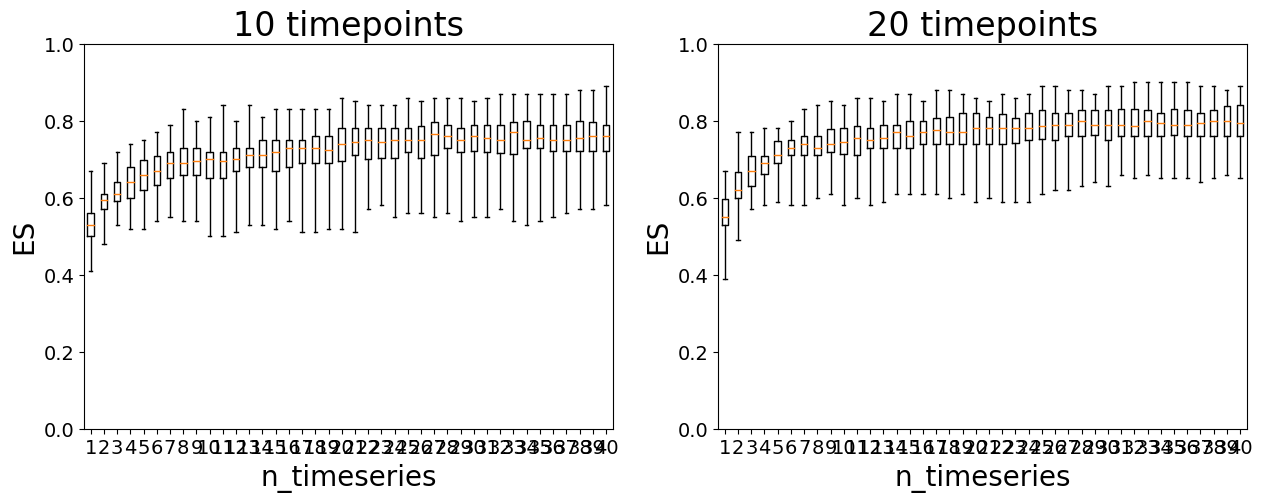

In [247]:
plt.subplots(1, 2, figsize=(15,5))
for j, n_tp in enumerate(df_n_sp["n_timepoints"].unique()):
    plt.subplot(1, 2, j+1)
    for i, n_ts in enumerate(df["n_timeseries"].unique()):
        plt.boxplot(df_n_sp[(df_n_sp[["n_timeseries", "n_timepoints"]]==[n_ts,n_tp]).all(1).values]["es_score_raw"].values, positions=[i], 
                    whis=(0, 100), widths=0.5)

    plt.xticks(np.arange(len(df["n_timeseries"].unique())), labels=df["n_timeseries"].unique().astype(int))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("n_timeseries", fontsize=20)
    plt.ylabel("ES", fontsize=20)
    plt.ylim(0, 1)
    plt.title(f"{n_tp:.0f} timepoints", fontsize=24)
plt.show()

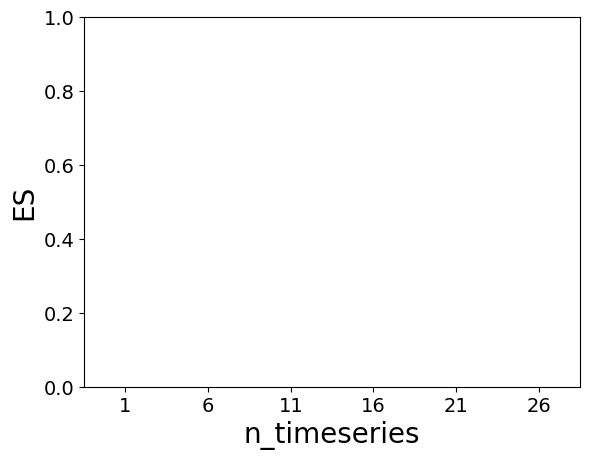

In [204]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    plt.boxplot(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries", "n_timepoints"]]==[0,n_ts,5]).all(1).values]["es_score_raw"].values, positions=[i],
                whis=(0, 100), widths=0.5)

plt.xticks(np.arange(len(df["n_timeseries"].unique())), labels=df["n_timeseries"].unique().astype(int))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("ES", fontsize=20)
plt.ylim(0, 1)
plt.show()

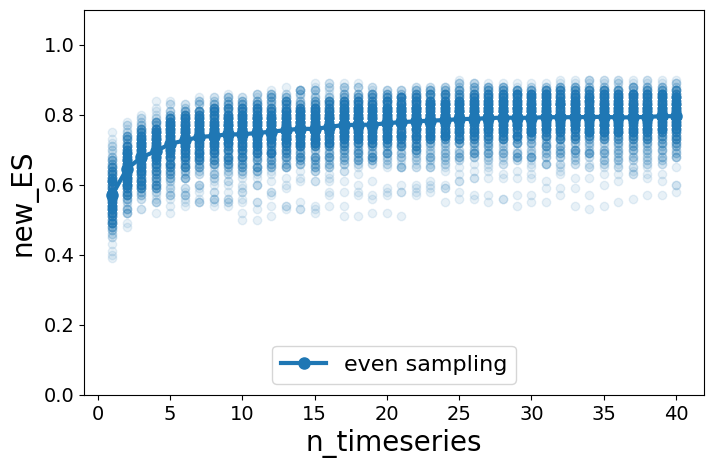

In [248]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df["sampling_scheme"].unique()):
        plt.scatter((n_ts+j)*np.ones_like(df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{j}", alpha=0.1)
        
for j, n_tp in enumerate(df["sampling_scheme"].unique()):
    plt.plot([i+j for i in df["n_timeseries"].unique()], [df_n_sp[(df_n_sp[["sampling_scheme", "n_timeseries"]]==[n_tp,i]).all(1).values]["es_score_raw"].values.mean() for i in df["n_timeseries"].unique()], c=f"C{j}", marker="o", ms=8, lw=3, label=f"{samp_schem[j]} sampling")

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("n_timeseries", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="lower center", fontsize=16)
plt.show()

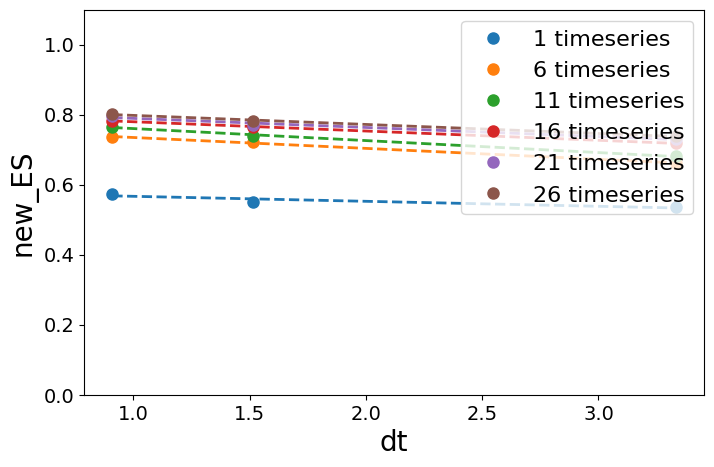

In [199]:
new_es_vs_dt = np.zeros((len(df_n_sp["n_timeseries"].unique()), len(df_n_sp["dt"].unique())))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp[df_n_sp["n_timeseries"]==n_ts]["dt"].unique()):
        new_es_vs_dt[i,j] = df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values.mean()

plt.figure(figsize=(8,5))
        
for i in range(new_es_vs_dt.shape[0]):
    new_es_vs_dt[i] = new_es_vs_dt[i][np.argsort(df_n_sp["dt"].unique())]
    lr = lm.LinearRegression()
    lr.fit(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())].reshape((-1,1)), new_es_vs_dt[i])
    plt.plot(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())], new_es_vs_dt[i], "o", c=f"C{i}", ms=8, label=f"{df_n_sp['n_timeseries'].unique()[i]:.0f} timeseries")
    plt.plot(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())], lr.predict(df_n_sp["dt"].unique()[np.argsort(df_n_sp["dt"].unique())].reshape((-1,1))), c=f"C{i}", ls="--", lw=2)
    
plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("dt", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.show()

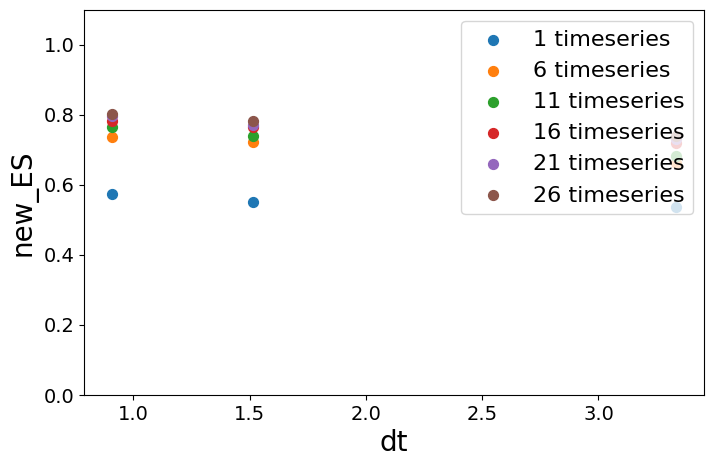

In [200]:
plt.figure(figsize=(8,5))

for i, n_ts in enumerate(df_n_sp["n_timeseries"].unique()):
    for j, n_tp in enumerate(df_n_sp[df_n_sp["n_timeseries"]==n_ts]["dt"].unique()):
        if j == 0:
            plt.scatter(n_tp, df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values.mean(), c=f"C{i}", s=50, label=f"{n_ts:.0f} timeseries")
        else:
            plt.scatter(n_tp, df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values.mean(), c=f"C{i}", s=50)

plt.ylim(0, 1.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("dt", fontsize=20)
plt.ylabel("new_ES", fontsize=20)
plt.legend(loc="upper right", fontsize=16)
plt.show()

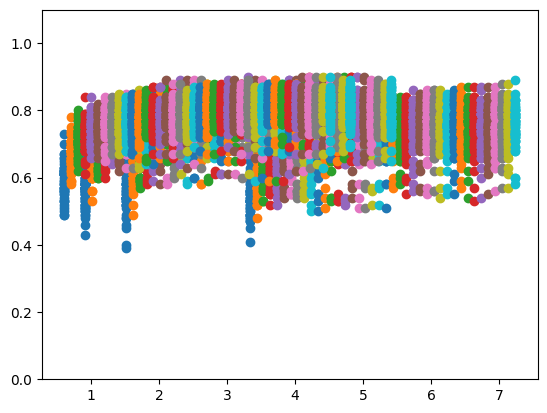

In [249]:
for i, n_ts in enumerate(df["n_timeseries"].unique()):
    for j, n_tp in enumerate(df[df["n_timeseries"]==n_ts]["dt"].unique()):
        plt.scatter((n_tp+i*0.1)*np.ones_like(df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values), df_n_sp[(df_n_sp[["dt", "n_timeseries"]]==[n_tp,n_ts]).all(1).values]["es_score_raw"].values, c=f"C{i}")
        
plt.ylim(0, 1.1)
# plt.xscale("log")
plt.show()